# Implementar o batch gradient descent

Desenvolva aqui o seu código para realizar o *batch gradient descent* a partir dos códigos [Gradiente Descendente por Lote](#gdl) (batch) e [Gradiente Descendente Estocástico](#gde), que fazem parte do notebook <a "href=https://t-adessowiki.fee.unicamp.br/user/lrittner/notebooks/ia368z_2s2017/aluno/week03/Regressao-Linear.ipynb">Regressao-Linear.ipynb</a>. A ideia é que o tamanho do lote possa assumir qualquer valor entre 1 e o número total de amostras. 

## Entrega do exercício

A entrega do exercício consiste do notebook com o seu código e a [figura salva conforme código abaixo](#figura). A figura deve ser composta por 3 plotagens do erro ao longo das iterações considerando um tam_lote = 1, tam_lote = T e tam_lote = num_amostras. Escolha T de tal forma que num_amostras/T não seja inteiro.

**Não altere o nome do notebook, o nome da figura salva, nem as dimensões da figura e o arranjo do subplot, pois estes parâmetros são necessários para facilitar a correção.**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

### Carregando dados e normalizando

In [2]:
iris = load_iris()

data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x = data[:,0:1]
y = data[:,1:2]

x -= x.min()
x /= x.max()    # normalização
y -= y.min()
y /= y.max()

### Gradiente Descendente por Mini Lote (mini-batch)

In [3]:
def mini_batch_gradient_descent(X, y, w_init, b, lr, n_epochs):
    '''
    Perform mini batch gradient descent to learn w
    by taking n_epochs times size of mini batch
    gradient steps with learning rate lr
    Dados rotulados: X.shape:(M, 2) e y.shape:(M,1)
    Parâmetro inicial: w_init.shape:(1,2) e b:(int)
    '''
    
    # abordagem inicial, mas custosa computacionalmente:
    # concatena a entrada com a saída esperada 
    # *** ATENÇÃO *** : gera uma nova matriz (copia elementos)
    #ALL_random = np.concatenate((X_bias, y), axis=1)
    # cria a view dos dados de entrada
    #X_bias2 = ALL_random[:, :X_bias.size//len(X_bias)]    
    # cria a view da saída esperada
    #y2 = ALL_random[:, X_bias.size//len(X_bias)]
    
    # quantidade de blocos
    M = int(y.size/b)
    # amostras restantes
    tail = y.size%b
    # hostórico de pesos
    w_history = np.zeros((2,(M*n_epochs)+1))
    # peso inicial
    wT = w_init.T
    # salva peso inicial no histórico
    w_history[:,0] = wT[:,0]
    
    for i in range(n_epochs):
        # embaralha os dados antes de uma nova época
        # abordagem inicial
        #np.random.shuffle(ALL_random)
        # pega o estado atual que será usado na 
        # próxima chamado do shuffle
        rng_state = np.random.get_state()
        # embaralha X
        np.random.shuffle(X)
        # seta o estado atual para o mesmo
        # usado no shuffle de X
        np.random.set_state(rng_state)
        # embaralha y
        np.random.shuffle(y)
        
        # inicial épocas
        for j in range(M):
            # elemento inicial do mini lote
            elemento_i = (j*b)
            # elemento final +1 do mini lote
            elemento_f = (j*b)+b
            # view do mini lote em X
            X_ = X[elemento_i:elemento_f]
            # view do mini lote em Y
            y_ = y[elemento_i:elemento_f]
            
            wT = wT - lr * (2.0 / b) * (X_.T).dot(X_.dot(wT) - y_)
            w_history[:,j+(i*M)+1] = wT[:,0]

        # caso o número de blocos não seja exato,
        # tratamos o último lote separadamente
        if (tail > 0):
            # view do último mini lote em X
            X_ = X[-tail:]
            # view do último mini lote em Y
            y_ = y[-tail:]

            wT = wT - lr * (2.0 / tail) * (X_.T).dot(X_.dot(wT) - y_)
            w_history[:,j+(i*M)+1] = wT[:,0]
            
    return w_history.T

### Minimização via gradiente descendente por mini lote

In [4]:
# Parâmetros do gradiente descendente: número de iterações e taxa de aprendizagem
iterations = 100
lr = 0.1

n_samples = y.shape[0]

#Montagem da matriz X agora com os elementos 1 na primeira coluna
X_bias = np.hstack([np.ones(shape=(n_samples,1)), x])
w_init = np.zeros(shape=(1,2))

tam_lote = 1
w_history_1 = mini_batch_gradient_descent(X_bias, y, w_init, tam_lote, lr, iterations)

tam_lote = 9
w_history_T = mini_batch_gradient_descent(X_bias, y, w_init, tam_lote, lr, iterations)

tam_lote = 50
w_history_M = mini_batch_gradient_descent(X_bias, y, w_init, tam_lote, lr, iterations)

In [5]:
def Jview(X_bias, y, w_history, w_opt, plt, ax):

    # parâmetros da função
    # quantos pesos gerar
    all = 100
    # valor mínimo do grid
    min = -0.45
    # valor máximo do grid
    max = 1.0
    
    # Cálculo da matriz bidimensional de parâmetros
    X, Y = np.meshgrid(np.linspace(min, max, all), 
                         np.linspace(min, max, all))
    wT = np.c_[X.ravel(), Y.ravel()].T
    
    # calculo do custo gerando uma matriz (all,all)
    #e = X_bias.dot(wT) - y
    #J = ((e * e).mean(axis=0)).reshape(all,all)
    J = compute_cost(X_bias, y, wT).reshape(all,all)
    
    # plotagem do espaço de parâmetros
    CS = plt.contourf(X, Y, J, 30, cmap=plt.cm.Blues_r)

    # plotagem do histórico dos pesos durante o treinamento
    w0 = w_history[0:,0]
    w1 = w_history[0:,1]
    plt.scatter(w0, w1, marker='o', c='r')

    # plotagem do da solução analítica
    plt.plot(w_opt[0], w_opt[1], 'wx')

    #plt.title('Visualização do treinamento de w na função de Custo J')
    
    #plt.savefig('fig_custo.png')
    
    #plt.show()

In [6]:
def compute_cost(X_b, y, wT):
    '''
    Compute cost for linear regression
    (X,y): amostras rotuladas X(n_samples,2) e y(n_samples,)
    wT: vetor coluna de parâmetros (já transposto)
       aceita tanto shape (2,1) Para um caso como (2,n_history) para n_history casos
    '''
    e = X_b.dot(wT) - y
    J = (e * e).mean(axis=0)
    return J

w_opt = (np.linalg.inv((X_bias.T).dot(X_bias)).dot(X_bias.T)).dot(y)

### Gerando a figura para correção automática

<a id='figura'></a>

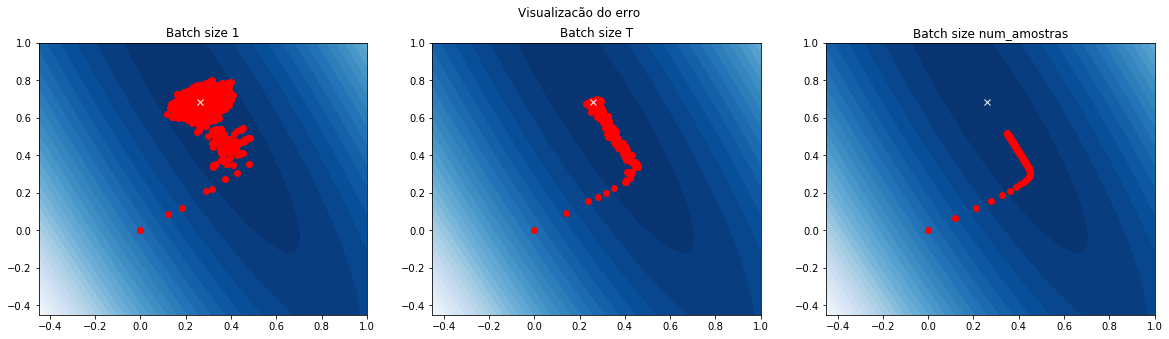

In [7]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Visualizacão do erro')

ax = fig.add_subplot(131)
plt.title("Batch size 1")
Jview(X_bias, y, w_history_1, w_opt, plt, ax)
#ax.plot(J_history_stochastic)

ay = fig.add_subplot(132)
plt.title("Batch size T")
Jview(X_bias, y, w_history_T, w_opt, plt, ay)
#ay.plot(J_history)

az = fig.add_subplot(133)
plt.title("Batch size num_amostras")
Jview(X_bias, y, w_history_M, w_opt, plt, az)
#az.plot(J_history)

plt.savefig('my_sgd_minibatch.png')

### Gradiente Descendente por Lote (*batch*)

<a id='gdl'></a>

In [1]:
def batch_gradient_descent(X, y, w_init, lr, n_epochs):
    '''
    Perform batch gradient descent to learn w
    by taking n_epochs gradient steps with learning
    rate lr
    Dados rotulados: X.shape:(M,2) e y.shape:(M,1)
    Parâmetro inicial: w_init.shape:(1,2)
    output: w_history:(num_epochs+1,2)
    '''
    M = y.size
    w_history = np.zeros((2,n_epochs+1))
    wT = w_init.T
    w_history[:,0] = wT[:,0]

    for i in range(n_epochs):
        wT = wT - lr * (2.0 / M) * (X.T).dot(X.dot(wT) - y)
        w_history[:,i+1]=wT[:,0]
    return w_history.T

### Gradiente Descendente Estocástico

<a id='gde'></a>

In [2]:
def stochastic_gradient_descent(X, y, w_init, lr, n_epochs):
    '''
    Perform stochastic gradient descent to learn w
    by taking n_epochs times number of samples 
    gradient steps with learning rate lr
    Dados rotulados: X.shape:(M,2) e y.shape:(M,1)
    Parâmetro inicial: w_init.shape:(1,2)
    output: w_history:(num_epochs+1,2)
    '''
    M = y.size
    w_history = np.zeros((2,(M*n_epochs)+1))
    wT = w_init.T
    w_history[:,0] = wT[:,0]

    for i in range(n_epochs):
        for jj in range(M):
            j = np.random.randint(M)
            wT = wT - lr * 2.0 * (X[j:j+1,:].T).dot(X[j:j+1,:].dot(wT) - y[j:j+1])
            w_history[:,jj+(i*M)+1] = wT[:,0]
    return w_history.T